Mounted at /content/drive

✅ Threshold (Mean |Kendall's Tau|): 0.1340
🎯 Fitur Terpilih: ['HighBP', 'HighChol', 'BMI', 'HeartDiseaseorAttack', 'GenHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']

🚀 MELATIH MODEL DNN + SELF-ATTENTION...
Epoch 1/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - accuracy: 0.5231 - loss: 0.9436 - val_accuracy: 0.5752 - val_loss: 0.8833
Epoch 2/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.5734 - loss: 0.8845 - val_accuracy: 0.5845 - val_loss: 0.8680
Epoch 3/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.5889 - loss: 0.8594 - val_accuracy: 0.5871 - val_loss: 0.8594
Epoch 4/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.6010 - loss: 0.8380 - val_accuracy: 0.5954 - val_loss: 0.8471
Epoch 5/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.6102 - loss: 0.8205 - val_accuracy: 0.6035 - val_loss: 0.8300
Epoch 6/100
8207/8207 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.6167 - loss: 0.8081 - 

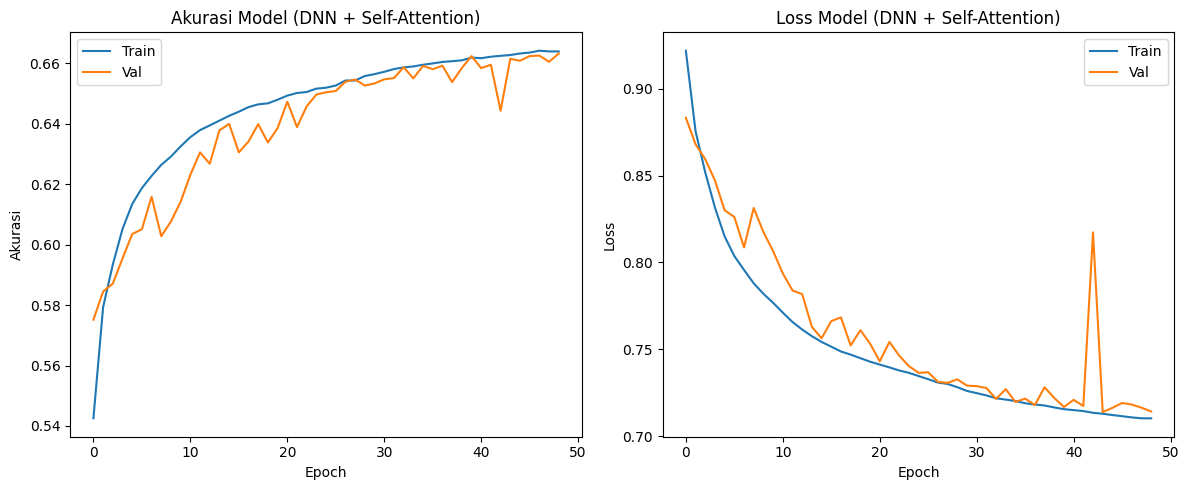

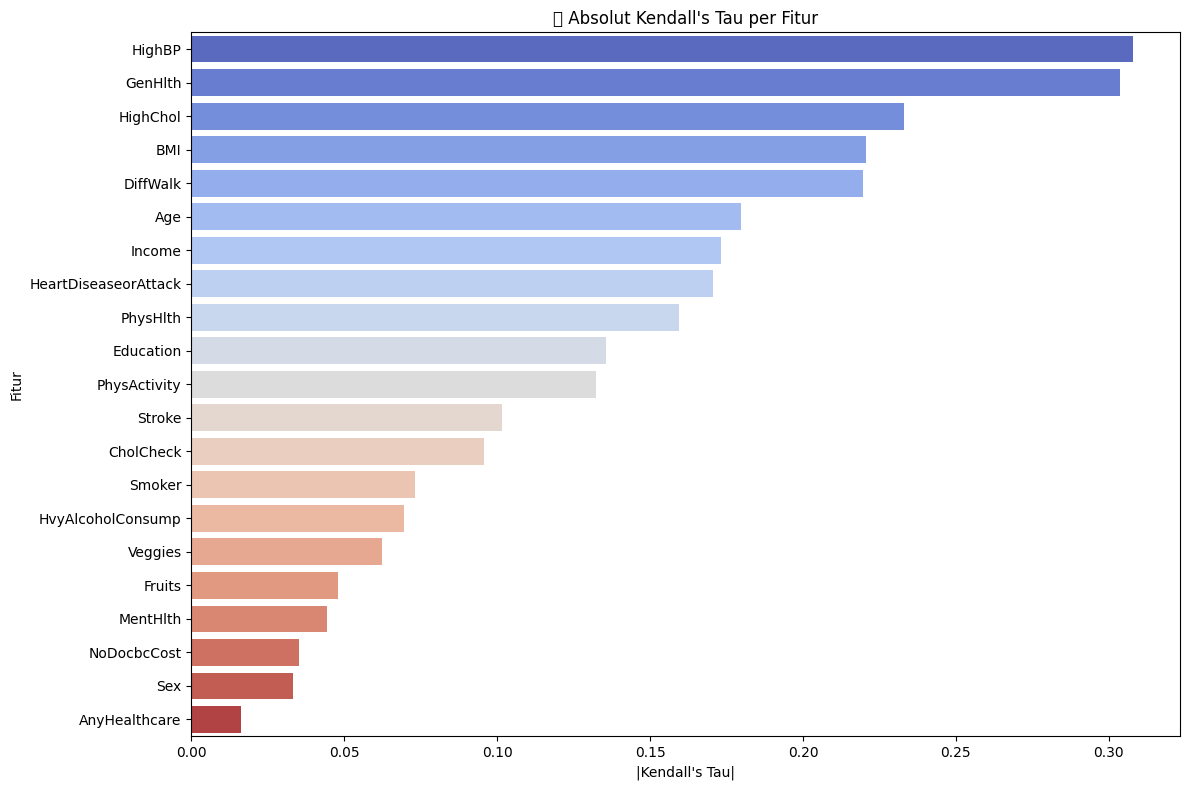

In [1]:
# ========================================
# IMPORT LIBRARY & SET SEED
# ========================================
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import kendalltau
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Lambda
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ========================================
# SET SEED
# ========================================
SEED = 44
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ========================================
# LOAD & PREPROCESS DATA
# ========================================
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Skripsi/Dataset/diabetes_012_health_indicators_BRFSS2015.csv')
X = data.drop('Diabetes_012', axis=1)
y = data['Diabetes_012']

# Winsorizing & Capping
X['BMI'] = winsorize(X['BMI'], limits=[0.005, 0.005])
X['MentHlth'] = np.where(X['MentHlth'] > 30, 30, X['MentHlth'])
X['PhysHlth'] = np.where(X['PhysHlth'] > 30, 30, X['PhysHlth'])

# Scaling
robust_features = ['BMI', 'MentHlth', 'PhysHlth']
minmax_features = ['Age', 'Education', 'Income', 'GenHlth']

scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()

X[robust_features] = scaler_robust.fit_transform(X[robust_features])
X[minmax_features] = scaler_minmax.fit_transform(X[minmax_features])

# ========================================
# SPLIT DATA AWAL
# ========================================
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ========================================
# SMOTE HANYA PADA TRAINING SET
# ========================================
smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train_raw, y_train)

# ========================================
# KENDALL'S CORRELATION SETELAH SMOTE
# ========================================
kendall_results = []
for feature in X_train_smote.columns:
    tau, p = kendalltau(X_train_smote[feature], y_train_smote)
    kendall_results.append({
        'Feature': feature,
        'Kendall_Tau': tau,
        'Abs_Kendall_Tau': abs(tau),
        'P_Value': p
    })

kendall_df = pd.DataFrame(kendall_results)
kendall_df_sorted = kendall_df.sort_values(by='Abs_Kendall_Tau', ascending=False)

mean_abs_tau = kendall_df['Abs_Kendall_Tau'].mean()
top_features = kendall_df[kendall_df['Abs_Kendall_Tau'] >= mean_abs_tau]['Feature'].tolist()
print(f"\n✅ Threshold (Mean |Kendall's Tau|): {mean_abs_tau:.4f}")
print(f"🎯 Fitur Terpilih: {top_features}")

# Filter fitur di training dan testing set
X_train_final = X_train_smote[top_features]
X_test_final = X_test_raw[top_features]

# One-hot encoding target
y_train_encoded = to_categorical(y_train_smote)
y_test_encoded = to_categorical(y_test)

# Split validation set dari training
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_final, y_train_encoded, test_size=0.2, random_state=SEED,
    stratify=y_train_encoded.argmax(axis=1)
)

# ========================================
# BUILD MODEL DENGAN SELF-ATTENTION
# ========================================
input_layer = Input(shape=(X_train_final.shape[1],))
x = Dense(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)

# Expand ke 3D untuk attention
x_expanded = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)

# Self-Attention Layer
attn_output = MultiHeadAttention(num_heads=4, key_dim=4)(x_expanded, x_expanded)
attn_output = LayerNormalization()(attn_output + x_expanded)

# Squeeze kembali ke 2D
x_final = Lambda(lambda t: tf.squeeze(t, axis=1))(attn_output)

# Output Layer
output_layer = Dense(3, activation='softmax')(x_final)

# Define model
model_sa = Model(inputs=input_layer, outputs=output_layer)
model_sa.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========================================
# TRAIN MODEL
# ========================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\n🚀 MELATIH MODEL DNN + SELF-ATTENTION...")
history_sa = model_sa.fit(
    X_train_main, y_train_main,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=50,
    callbacks=[early_stop],
    verbose=1
)

# ========================================
# EVALUASI
# ========================================
y_pred_prob_sa = model_sa.predict(X_test_final, verbose=0)
y_pred_class_sa = np.argmax(y_pred_prob_sa, axis=1)
y_true_class_sa = np.argmax(y_test_encoded, axis=1)

print("\n=== 📋 CLASSIFICATION REPORT ===")
print(classification_report(y_true_class_sa, y_pred_class_sa, digits=4))

roc_auc_sa = roc_auc_score(y_test_encoded, y_pred_prob_sa, average='macro', multi_class='ovr')
print(f"\n📈 ROC AUC (Macro Average): {roc_auc_sa:.4f}")

# ========================================
# VISUALISASI AKURASI & LOSS
# ========================================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_sa.history['accuracy'], label='Train')
plt.plot(history_sa.history['val_accuracy'], label='Val')
plt.title('Akurasi Model (DNN + Self-Attention)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_sa.history['loss'], label='Train')
plt.plot(history_sa.history['val_loss'], label='Val')
plt.title('Loss Model (DNN + Self-Attention)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# ========================================
# VISUALISASI NILAI TAU PER FITUR
# ========================================
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Abs_Kendall_Tau',
    y='Feature',
    data=kendall_df_sorted,
    palette='coolwarm'
)
plt.title("🔍 Absolut Kendall's Tau per Fitur")
plt.xlabel('|Kendall\'s Tau|')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()
